# Electroencephalogram example

This dataset contains EEG recordings from human neonates. Multi-channel EEG was recorded from 79 term neonates admitted to the neonatal intensive care unit (NICU) at the Helsinki University Hospital. The median recording duration was 74 minutes (IQR: 64 to 96 minutes).

In [1]:
import numpy as np
import mogptk
import pandas as pd
import torch

np.random.seed(1)

# MOGP prediction on the sensor values

We use eight of the twenty two sensor's values as channel, leaving us with eight channels to fit using multi output Gaussian processes in order to find cross correlations between the channels. 

In [2]:
dataset_pd = pd.read_csv('data/eeg.csv',header=0,index_col=0)
cols = ['EEG Fp1-Ref','EEG Fp2-Ref','EEG Fz-Ref','EEG Cz-Ref','EEG T3-Ref','EEG T4-Ref','EEG O1-Ref','EEG O2-Ref']
t = dataset_pd['time'].values
y = dataset_pd[cols].values

data = mogptk.DataSet()
for i in range(len(cols)):
    data.append(mogptk.Data(t, y[:, i], name=cols[i]))

for i, channel in enumerate(data):
    channel.transform(mogptk.TransformNormalize())
    channel.remove_randomly(pct=0.4)
    
    if i not in [0,1, 2, 3, 5, 7]:
        channel.remove_range(45, None)

# simulate sensor failure
data[0].remove_range(25, 35)
data[5].remove_range(None, 10)
data[7].remove_range(None, 10)        

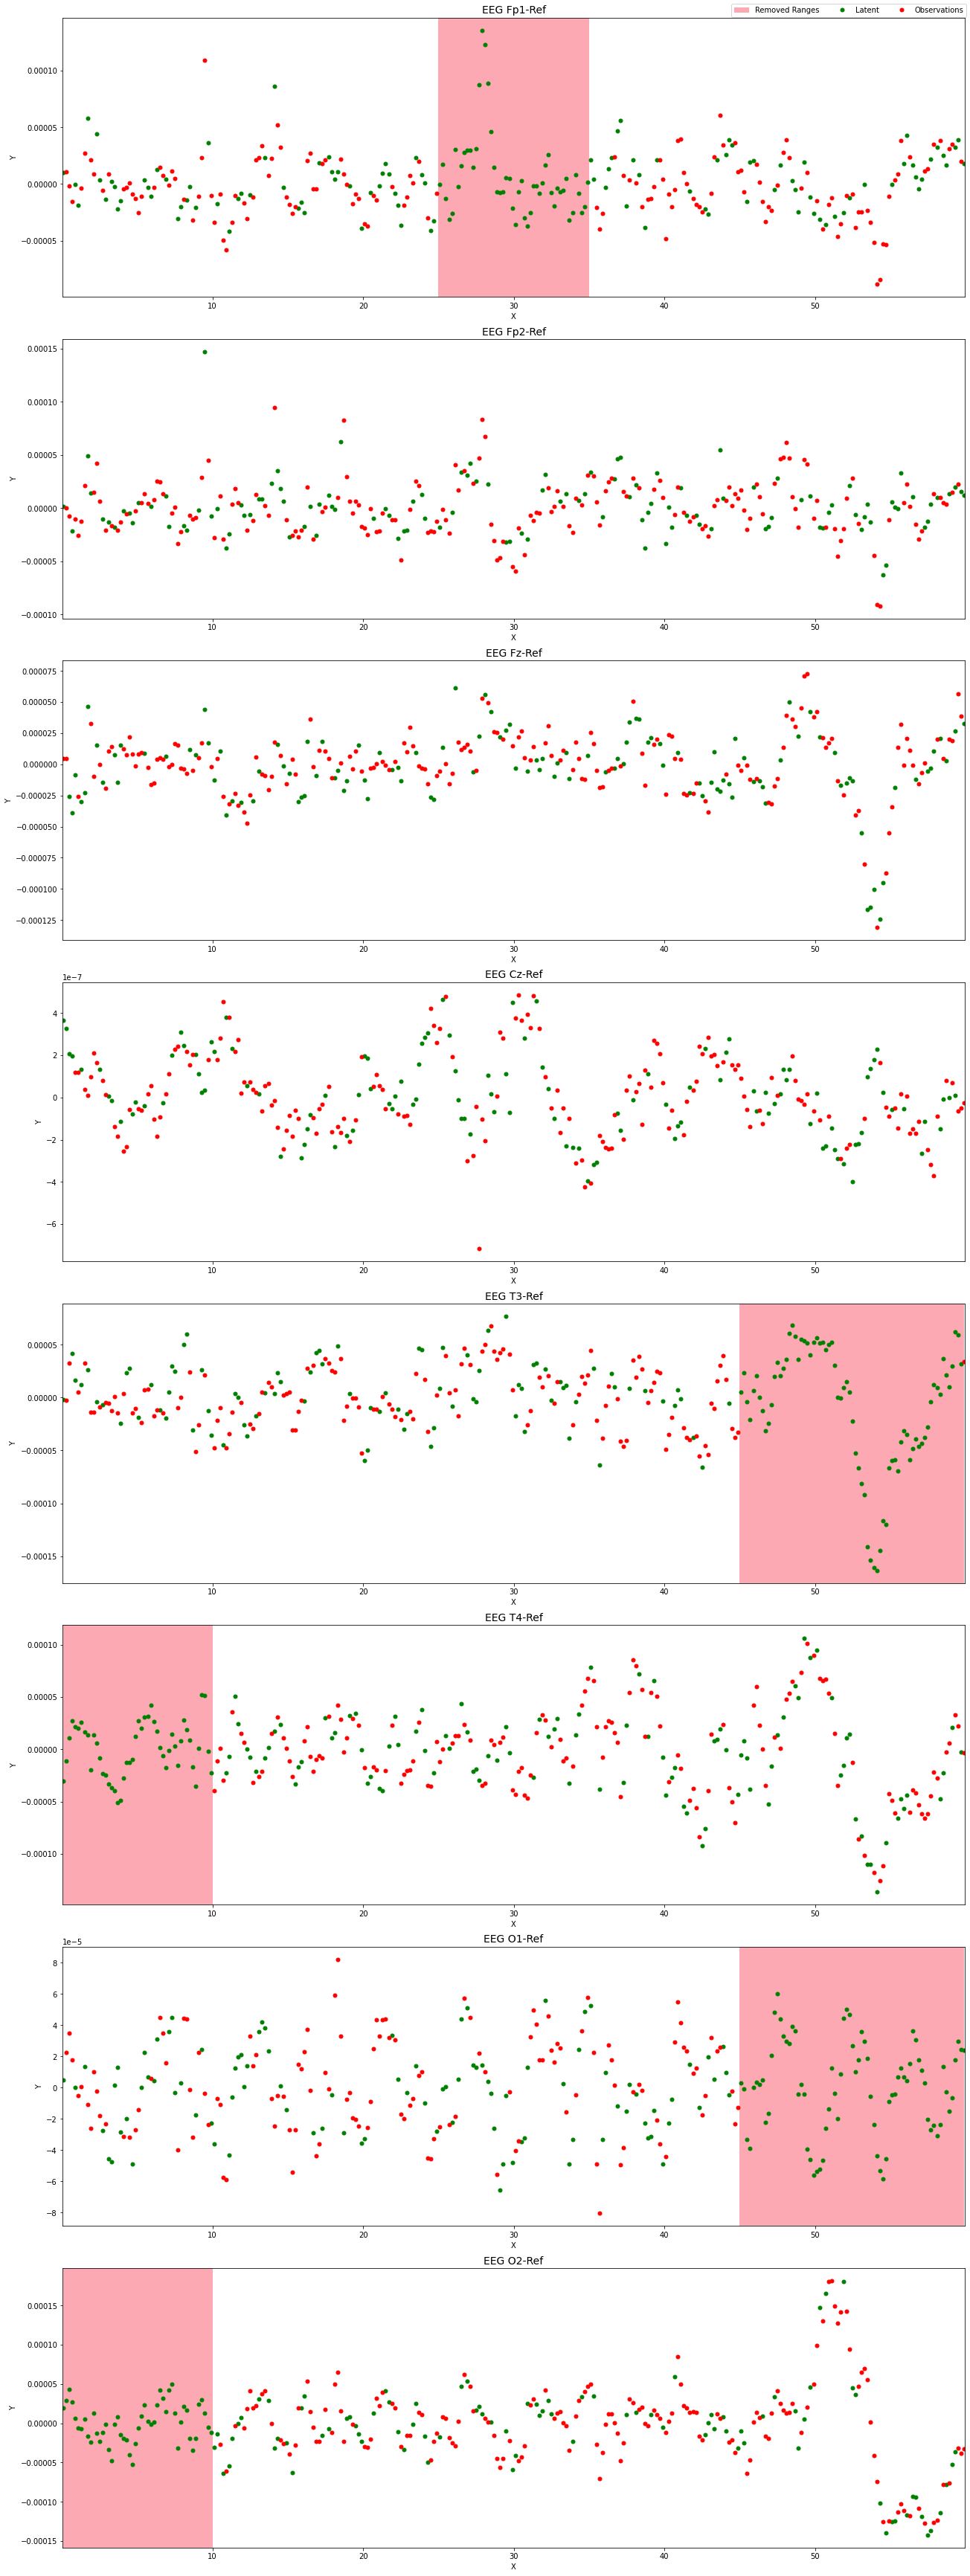

In [3]:
data.plot();

### Model training


Starting optimization using Adam
‣ Model: MOHSM
‣ Channels: 8
‣ Parameters: 204
‣ Training points: 1265
‣ Initial loss: 1249.46
‣ Initial error: 2.88558e-05

Start Adam:
    0/400   0:00:03  loss=     1249.46  error= 2.88558e-05
    4/400   0:00:20  loss=     1204.49  error= 2.86722e-05
    8/400   0:00:37  loss=     1161.65  error= 2.87232e-05
   12/400   0:00:54  loss=     1119.39  error= 2.88007e-05
   16/400   0:01:10  loss=     1077.42  error= 2.87922e-05
   20/400   0:01:26  loss=     1036.37  error= 2.88113e-05
   24/400   0:01:44  loss=     995.901  error= 2.89047e-05
   28/400   0:02:00  loss=     956.301  error= 2.89434e-05
   32/400   0:02:17  loss=     917.417  error=  2.8951e-05
   36/400   0:02:33  loss=      879.38  error= 2.89157e-05
   40/400   0:02:50  loss=     842.203  error= 2.88625e-05
   44/400   0:03:07  loss=     806.025  error= 2.88363e-05
   48/400   0:03:24  loss=     770.834  error= 2.88819e-05
   52/400   0:03:40  loss=      736.62  error= 2.89305e-05
   

Name,Range,Value
Mixture[0].MOHSM.weight,"[1e-08, ∞)",[9.56417766 4.31908331 6.50562154 6.46525677 4.81299564 8.56451074 7.02364936 8.90889109]
Mixture[0].MOHSM.mean,"[1e-08, ∞)",[[0.02549104] [0.23747579] [0.0940852 ] [0.05668663] [0.02541778] [0.08369347] [0.20351463] [0.08385606]]
Mixture[0].MOHSM.variance,"[1e-08, ∞)",[[9.84772739e-05] [1.13710101e-04] [5.78241497e-04] [2.64049394e-04] [8.17668270e-05] [1.72471227e-03] [5.43362127e-04] [4.26498943e-03]]
Mixture[0].MOHSM.lengthscale,"[1e-08, ∞)",[0.00405632 0.00200596 0.00288502 0.00222919 0.00338237 0.00263217 0.00183108 0.00262867]
Mixture[0].MOHSM.center,"(-∞, ∞)",[5.69423539]
Mixture[0].MOHSM.delay,"(-∞, ∞)",[[ 3.40386784] [-0.23420072] [ 0.76156157] [ 0.64975614] [-1.16957554] [ 1.26906993] [ 0.23420072] [-1.17658926]]
Mixture[0].MOHSM.phase,"(-∞, ∞)",[ 0.89169945 -0.22572085 0.75435152 0.24842922 1.2647724 -0.36961333 0.22572085 -0.0476424 ]
Mixture[1].MOHSM.weight,"[1e-08, ∞)",[5.92660805 4.16041503 4.91548693 8.2709504 6.1945013 6.13877519 7.37456912 6.03555051]
Mixture[1].MOHSM.mean,"[1e-08, ∞)",[[0.07238981] [0.04048969] [0.07259066] [0.16766437] [0.07252619] [0.07217512] [0.34827757] [0.1049849 ]]
Mixture[1].MOHSM.variance,"[1e-08, ∞)",[[1.03102851e-04] [4.29638223e-05] [5.59670909e-05] [1.19854508e-04] [7.16697260e-05] [1.73783272e-05] [1.87286830e-04] [3.06911893e-05]]


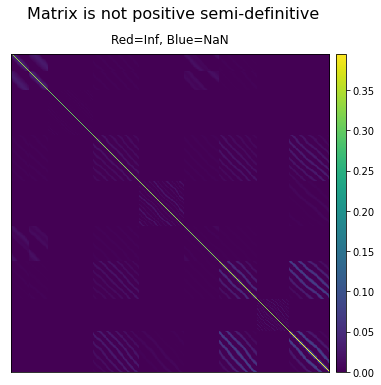

CholeskyException: torch.linalg_cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1258 is not positive-definite).

In [6]:
model = mogptk.MOHSM(data, Q=2, P=2)
model.init_parameters('BNSE')
model.train(method='Adam', lr=0.1, iters=400, verbose=True, error='MAE')

### Prediction

In [ ]:
model.plot_prediction(transformed=True);